In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('seaborn')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
#import models
from tqdm import tqdm
import train_reg
import config
import pandas as pd
import features
from scipy.stats import skew, pearsonr
#df = data.get_tracks() # note: different Xs can be different shapes
#df = data.remove_invalid_tracks(df)
#df = data.preprocess(df)
#df = data.add_outcome(df)
#n = df.shape[0]

/accounts/grad/xsli/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/accounts/grad/xsli/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
dset = 'clath_aux_dynamin'
outcome_def = 'Z_sig_mean'
#out_dir = 'results/regression/Sep15'

In [7]:
feat_names = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime',
              'X_d1',
              'X_d2',
              'X_d3'
             ]

In [4]:
df = pd.read_pickle(f'../data/tracks/tracks_{dset}.pkl')

In [6]:
df = df[df.catIdx.isin([1, 2])]
df = df[df.lifetime > 15]
df = features.add_basic_features(df)
df = train_reg.log_transforms(df)
df = features.add_dasc_features(df, bins=100, by_cell=True)
df = train_reg.add_sig_mean(df)
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

../src/train_reg.py:82: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


In [19]:
df_train = df_train.dropna()
for features in ['dasc', 
                 'basic', 'combined'
                ]:
    if features == 'dasc':
        use_feature = feat_names[6:]
    elif features == 'basic':
        use_feature = feat_names[:6]
    else:
        use_feature = feat_names
    out_dir = f'results/regression/Oct14_Y_{features}'
    outcome_def = 'Y_sig_mean'
    os.makedirs(out_dir, exist_ok=True)
    for model_type in tqdm(['linear', 'gb', 'rf', 'ridge']):
        out_name = f'{model_type}'
                            #print(out_name)
        #if use_processed and os.path.exists(f'{out_dir}/{out_name}.pkl'):
        #    continue
        train_reg.train_reg(df_train, feat_names=use_feature, model_type=model_type, 
                         outcome_def=outcome_def,
                         out_name=f'{out_dir}/{out_name}.pkl') 

100%|██████████| 4/4 [07:52<00:00, 118.11s/it]


In [20]:
for features in ['dasc', 
                 'basic', 'combined'
                ]:
    if features == 'dasc':
        use_feature = feat_names[6:]
    elif features == 'basic':
        use_feature = feat_names[:6]
    else:
        use_feature = feat_names
    m = pd.read_pickle(f'results/regression/Oct14_Y_{features}/gb.pkl')
    df_test = df_test.dropna()
    test_preds = train_reg.test_reg(df_test, m['model'], feat_names=use_feature, outcome_def=outcome_def)
    print(f"R^2 with {features} features: {test_preds['r2']}")

R^2 with dasc features: 0.38202260602717586
R^2 with basic features: 0.40579981656959496
R^2 with combined features: 0.40979757747746537


### Max strength prediction

In [91]:
train_reg.load_and_train(dset, outcome_def, out_dir, feat_names=feat_names)

/accounts/grad/xsli/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
../src/train_reg.py:81: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05
100%|██████████| 5/5 [16:28<00:00, 182.89s/it]


In [14]:
df = train_reg.add_sig_mean(df)

../src/train_reg.py:77: RuntimeWarning: invalid value encountered in less
  sig_mean.append(0)


In [7]:
df = df[df.catIdx.isin([1, 2])]
df = df[df.lifetime > 15]

In [12]:
df = features.add_basic_features(df)
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 

In [94]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r['r2']

model_type
svm       0.148
rf        0.196
linear    0.200
gb        0.225
ridge     0.200
Name: r2, dtype: float64

In [97]:
m = pd.read_pickle(f'{out_dir}/gb.pkl')

In [103]:
df_test = df_test.dropna()
test_preds = train_reg.test_reg(df_test, m['model'], outcome_def=outcome_def)

In [1]:
test_preds

NameError: name 'test_preds' is not defined

In [3]:
df = pd.read_pickle('../data/tracks/tracks_clath_aux_dynamin.pkl')

In [4]:
df = train_reg.add_sig_mean(df)

../src/train_reg.py:82: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


  0%|          | 1/259739 [00:00<25:07:22,  2.87it/s]/accounts/grad/xsli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys
/accounts/grad/xsli/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 259739/259739 [02:52<00:00, 1508.49it/s]


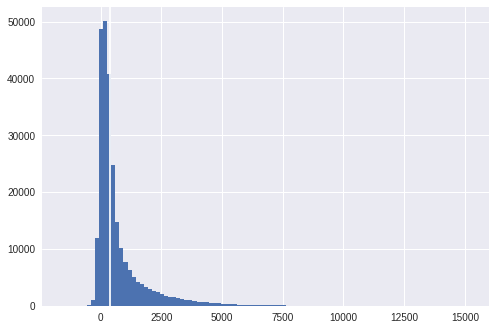

In [11]:
df['Z_max'] = [max(z) for z in df['Z']]
df['Y_max_sig'] = np.nan
df['Z_max_sig'] = np.nan
for i in tqdm(range(df.shape[0])):
    r = df.iloc[i]
    try:
        df['Y_max_sig'].iloc[i] = max(np.array(r['Y'])[np.array(r['Y_pvals']) < 0.05])
    except:
        pass
    try:
        df['Z_max_sig'].iloc[i] = max(np.array(r['Z'])[np.array(r['Z_pvals']) < 0.05])
    except:
        pass
plt.hist(df['Z_max'], bins=100)
plt.axvline(390)
plt.show()

In [168]:
df = add_dasc_features(df, bins=100, by_cell=True)

100%|██████████| 43926/43926 [00:20<00:00, 2136.02it/s]


In [178]:
df = train_reg.log_transforms(df)
df = train_reg.add_sig_mean(df)
df_train = df[df.cell_num.isin(config.DSETS[dset]['train'])] 
df_test = df[df.cell_num.isin(config.DSETS[dset]['test'])] 
df_train = df_train.dropna()

/accounts/grad/xsli/.local/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
../src/train_reg.py:82: RuntimeWarning: invalid value encountered in less
  sigs = np.array(r[f'{track}_pvals']) < 0.05


In [206]:
feat_names = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime',
              'X_d1',
              'X_d2',
              'X_d3'
             ]

In [210]:
out_dir = 'results/regression/Oct14_Z'
outcome_def = 'Z_sig_mean'
os.makedirs(out_dir, exist_ok=True)
for model_type in tqdm(['linear', 'gb', 'rf', 'ridge']):
    out_name = f'{model_type}'
                        #print(out_name)
    #if use_processed and os.path.exists(f'{out_dir}/{out_name}.pkl'):
    #    continue
    train_reg.train_reg(df_train, feat_names=feat_names, model_type=model_type, 
                     outcome_def=outcome_def,
                     out_name=f'{out_dir}/{out_name}.pkl') 

100%|██████████| 4/4 [08:39<00:00, 101.97s/it]


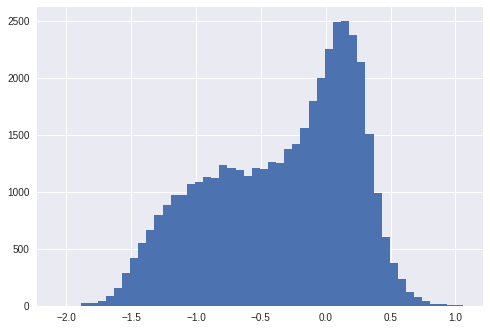

In [173]:
plt.hist(df['X_d1'], bins=50)
plt.show()

In [211]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r['r2']

model_type
linear    0.204
rf        0.167
gb        0.219
ridge     0.204
Name: r2, dtype: float64

In [203]:
feat_names = ['mean_square_displacement',
              'mean_total_displacement',
              'X_max',
              'X_mean',
              'X_std',
              'lifetime',
             ]
out_dir = 'results/regression/Oct14_Z2'
outcome_def = 'Z_sig_mean'
os.makedirs(out_dir, exist_ok=True)
for model_type in tqdm(['linear', 'gb', 'rf', 'ridge']):
    out_name = f'{model_type}'
                        #print(out_name)
    #if use_processed and os.path.exists(f'{out_dir}/{out_name}.pkl'):
    #    continue
    train_reg.train_reg(df_train, feat_names=feat_names, model_type=model_type, 
                     outcome_def=outcome_def,
                     out_name=f'{out_dir}/{out_name}.pkl') 

100%|██████████| 4/4 [05:43<00:00, 67.57s/it]


In [204]:
results = train_reg.load_results(out_dir)
r = results
r = r[[k for k in r if not 'std' in k]]
r = r[[k for k in r if not '_f' in k]]
# r = r[r.index.str.contains('ros')] # only use random sampling
r['r2']

model_type
rf        0.167
linear    0.193
ridge     0.193
gb        0.218
Name: r2, dtype: float64

In [212]:
m = pd.read_pickle('results/regression/Oct14_Z/gb.pkl')
df_test = df_test.dropna()
test_preds = train_reg.test_reg(df_test, m['model'], feat_names=feat_names, outcome_def=outcome_def)

In [213]:
test_preds

{'preds': array([504.83189264, 597.79311845, 357.71997372, ..., 279.30316085,
        827.68287023, 473.28020911]),
 'r2': 0.27660053385079253,
 'pearsonr': (0.5278621312738783, 0.0)}

In [205]:
m = pd.read_pickle('results/regression/Oct14_Z2/gb.pkl')
df_test = df_test.dropna()
test_preds = train_reg.test_reg(df_test, m['model'], feat_names=feat_names[:6], outcome_def=outcome_def)
test_preds

{'preds': array([515.37898705, 588.43487852, 360.31006304, ..., 352.18198644,
        939.37737249, 481.11970375]),
 'r2': 0.26396074093469224,
 'pearsonr': (0.5170522292285932, 0.0)}